In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt


class Enviroment:
    def __init__(self, is_bernoulli, no_arms=10):
        self.no_arms = no_arms
        
        self.pull_arm = self.pull_arm_bernaulli if is_bernoulli else self.pull_arm_gaussion
            
        self.arms = {}
        for arm in range(self.no_arms):
            self.arms[arm] = np.random.rand()
        
        self.best_arm = np.argmax([[self.arms[arm] for arm in range(self.no_arms)]])
        
    def update(self):
        for arm in range(self.no_arms):
            self.arms[arm] = np.random.rand()
        self.best_arm = np.argmax([[self.arms[arm] for arm in range(self.no_arms)]])
        
    def pull_arm_bernaulli(self, arm):
        return 1 if self.arms[arm] > np.random.rand() else 0
    
    def pull_arm_gaussion(self, arm):
        return np.random.normal(self.arms[arm], scale=0.1)
    
        

In [2]:
class AgentUCB:
    def __init__(self, no_arms=10):
        self.no_arms = no_arms
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['likely'] = 0
            self.info[arm]['no_visited'] = 0
            self.info[arm]['is_visited'] = False
            self.info[arm]['value'] = 0
        self.round = 0
        self.score = 0
        
    def pull(self):
        self.round += 1
        
        for arm in range(self.no_arms):
            if not self.info[arm]['is_visited']:
                self.info[arm]['is_visited'] = True
                self.info[arm]['no_visited'] += 1
                return arm
            
        arm = np.argmax(np.asarray([self.info[arm]['likely'] for arm in range(self.no_arms)]))
        self.info[arm]['no_visited'] += 1
        
        return arm
    
    def reset(self):
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['likely'] = 0
            self.info[arm]['no_visited'] = 0
            self.info[arm]['is_visited'] = False
            self.info[arm]['value'] = 0
        self.round = 0    
    
    def update(self, action, reward):
        
        self.info[action]['value'] += (reward-self.info[action]['value'])/self.info[action]['no_visited']
        
        if all([self.info[arm]['is_visited'] for arm in range(self.no_arms)]):
            for arm in range(self.no_arms):
                self.info[arm]['likely'] = self.info[arm]['value'] + \
                np.sqrt((2*np.log(self.round))/self.info[arm]['no_visited'])
                
            
        

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable

import copy
import operator


class Model(torch.nn.Module):
    def __init__(self, num_inputs, action_space,settings={}):
        super(Model, self).__init__()

        #should hidden units have biases?
        _b = True
        hid_layers = 2  #how many hidden layers
        sz = 64 #how many neurons per layer

        num_outputs = action_space

        #overwritable defaults
        af = nn.ReLU 
        oaf = nn.Sigmoid
        

        afunc = {'relu':nn.ReLU,'tanh':nn.Tanh,'linear':lambda : linear,'sigmoid':nn.Sigmoid}
        
        self.stddev = 0.1
        self._af = af
        self.af = af()
        self.sigmoid = oaf()
        self.softmax = nn.Softmax(dim=0)

        #first fully-connected layer changing from input-size representation to hidden-size representation
        self.fc1 = nn.Linear(num_inputs, sz, bias=_b) 

        self.hidden_layers = []

        #create all the hidden layers
        for x in range(hid_layers):
            self.hidden_layers.append(nn.Linear(sz, sz, bias=True))
            self.add_module("hl%d"%x,self.hidden_layers[-1])

        #create the hidden -> output layer
        self.fc_out = nn.Linear(sz, num_outputs, bias=_b)

        self.train()

    def forward(self, inputs, intermediate=None, debug=False):

        x = inputs
        x = torch.cat(x)
        #fully connection input -> hidden
        x = self.fc1(x.float())
            
        x = self._af()(x)
        
        #propagate signal through hidden layers
        for idx,layer in enumerate(self.hidden_layers):

            #do fc computation
            x = layer(x)

            #run it through activation function
            x = self._af()(x)

            if intermediate == idx:
                cached = x
        
        #output layer
        x = self.fc_out(x)
        #Add noise
        x = x+torch.autograd.Variable(torch.randn(x.size()).cpu() * self.stddev)
        #softmax
        x = self.softmax(x)

        if intermediate!=None:
            return x,cached

        return x
    
    #function to grab current flattened neural network weights
    def extract_parameters(self):
        tot_size = self.count_parameters()
        pvec = np.zeros(tot_size, np.float32)
        count = 0
        for param in self.parameters():
            sz = param.data.numpy().flatten().shape[0]
            pvec[count:count + sz] = param.data.numpy().flatten()
            count += sz
        return pvec.copy()
    
    #function to inject a flat vector of ANN parameters into the model's current neural network weights
    def inject_parameters(self, pvec):
        tot_size = self.count_parameters()
        count = 0

        for param in self.parameters():
            sz = param.cpu().data.numpy().flatten().shape[0]
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.cpu().data.numpy().shape)
            param.data = torch.from_numpy(reshaped).float()
            count += sz

        return pvec

    #count how many parameters are in the model
    def count_parameters(self):
        count = 0
        for param in self.parameters():
            #print param.data.numpy().shape
            count += param.cpu().data.numpy().flatten().shape[0]
        return count

class Individual:
    def __init__(self, no_arms=10, mag=0.1, trials=50):
        self.no_arms = no_arms
        self.mag = mag
        self.trials = trials
        self.net_rwd = 0
        self.score = 0
        self.fitness = 0
        self.played = False
        self.model = Model(no_arms*2, no_arms)
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['no_visited'] = 0
            self.info[arm]['value'] = 0
        
    def pull(self):
        visits = torch.Tensor(np.array([self.info[arm]['no_visited'] for arm in range(self.no_arms)]))
        values = torch.Tensor(np.array([self.info[arm]['value'] for arm in range(self.no_arms)]))
        actions = self.model([visits, values])
        try:
            arm = np.random.choice(self.no_arms, 1, p=actions.detach().numpy())[0]
        except:
            raise TypeError("check", actions)
        self.info[arm]['no_visited'] += 1
        return arm
    
    def reset(self):
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['no_visited'] = 0
            self.info[arm]['value'] = 0
    
    def mutate(self, mu, sigma=0.1, mag=None):
        if mag==None:
            mag = self.mag
        parameters = self.model.extract_parameters()
        pertubation = np.array([np.random.normal(loc=mean, scale=mag) for mean in mu])
        updated_paramaters = pertubation
        child = Individual(self.no_arms, self.mag, self.trials)
        child.model.inject_parameters(updated_paramaters.astype(float)) 
        return child
    
    def run(self, envs):
        if not self.played:
            for env in envs:
                for _ in range(self.trials):
                    arm = self.pull()
                    r = env.pull_arm(arm)
                    self.info[arm]['value'] += (r-self.info[arm]['value'])/self.info[arm]['no_visited']
                    self.net_rwd += r 
                    self.score += int(arm==env.best_arm)
                self.reset()
            self.fitness += self.score/(self.trials*len(envs))
            self.played = True
        
        


In [4]:
paramaters = {
    'psize': [10, 25, 50, 100, 200, 500],
    'mag': [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.2, 0.5],
    'greedy_kill': [1, 3, 5, 10],
    'size': [4, 8, 16, 32, 64],
    'layers': [1, 2, 3, 4, 5],
    'arms': [2, 4, 8, 16, 32, 64],
    'marks': [1/5, 1/10, 1/20, 1/50, 1/100]
}

In [5]:
paramaters

{'psize': [10, 25, 50, 100, 200, 500],
 'mag': [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.2, 0.5],
 'greedy_kill': [1, 3, 5, 10],
 'size': [4, 8, 16, 32, 64],
 'layers': [1, 2, 3, 4, 5],
 'arms': [2, 4, 8, 16, 32, 64],
 'marks': [0.2, 0.1, 0.05, 0.02, 0.01]}

Generation:  0
pop fitness 0.09931999999999999
elite fitness 0.1216
Generation:  1
pop fitness 0.10935999999999998
elite fitness 0.1268
Generation:  2
pop fitness 0.11484
elite fitness 0.134
Generation:  3
pop fitness 0.11899999999999998
elite fitness 0.13840000000000002
Generation:  4
pop fitness 0.12368
elite fitness 0.14200000000000002
Generation:  5
pop fitness 0.12864
elite fitness 0.14520000000000002
Generation:  6
pop fitness 0.134
elite fitness 0.1504
Generation:  7
pop fitness 0.13724
elite fitness 0.152
Generation:  8
pop fitness 0.14308
elite fitness 0.16440000000000002
Generation:  9
pop fitness 0.15496000000000001
elite fitness 0.17959999999999998
Generation:  10
pop fitness 0.16532
elite fitness 0.1944
Generation:  11
pop fitness 0.17784
elite fitness 0.202
Generation:  12
pop fitness 0.1898
elite fitness 0.21880000000000002
Generation:  13
pop fitness 0.19640000000000002
elite fitness 0.2192
Generation:  14
pop fitness 0.20592
elite fitness 0.23440000000000003
Generation

Generation:  124
pop fitness 0.35288
elite fitness 0.40040000000000003
Generation:  125
pop fitness 0.36948000000000003
elite fitness 0.40040000000000003
Generation:  126
pop fitness 0.366
elite fitness 0.40040000000000003
Generation:  127
pop fitness 0.36644
elite fitness 0.40040000000000003
Generation:  128
pop fitness 0.361
elite fitness 0.40040000000000003
Generation:  129
pop fitness 0.3645999999999999
elite fitness 0.40040000000000003
Generation:  130
pop fitness 0.34840000000000004
elite fitness 0.40040000000000003
Generation:  131
pop fitness 0.35907999999999995
elite fitness 0.40040000000000003
Generation:  132
pop fitness 0.34564
elite fitness 0.40040000000000003
Generation:  133
pop fitness 0.35392
elite fitness 0.40040000000000003
Generation:  134
pop fitness 0.35240000000000005
elite fitness 0.40040000000000003
Generation:  135
pop fitness 0.3520399999999999
elite fitness 0.40040000000000003
Generation:  136
pop fitness 0.35603999999999997
elite fitness 0.40040000000000003

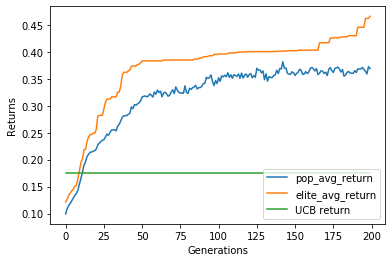

In [6]:
import random
from functools import reduce

# population size
psize = 50
#mutation magnitude
mag = 0.1
# number of generations
generations = 200
#number of arms
no_arms = 10

#Number of samples for each bandit problem
trials = 50

greedy_kill=5


#setting the enviroment
envs  = [Enviroment(is_bernoulli=True, no_arms=no_arms) for _ in range(10)]

#set of elite agent
elite = [None]*5

#counter
k=0

# Average rewards for ES
avg_elite_rwd = 0
avg_rwd = 0
rwds = []
elite_rwds = []

#initilizing population
population = []
for _ in range(psize):
    population.append(Individual(no_arms=no_arms, mag=mag, trials=trials))
    population[-1].run(envs)
  
    
for gen in range(generations):
    
    #Getting elite agent
    values = [[copy.deepcopy(ind), ind.fitness] for ind in population]
    values.sort(key = operator.itemgetter(1))
    for x in enumerate(values[-(1+len(elite)):-1]):
        elite[x[0]] =  x[1][0]
    
            
    rwds.append(np.mean([ind.fitness for ind in population]))
    elite_rwds.append(np.mean([ind.fitness for ind in elite]))
    print('Generation: ', gen)
    print('pop fitness', np.mean([ind.fitness for ind in population]))
    print('elite fitness', np.mean([ind.fitness for ind in elite]))
    
    # Finding mean parameters of elite agent
    mu = np.mean([ind.model.extract_parameters() for ind in elite], axis=0)
    
    children = [ind.mutate(mu) for ind in population]
    [child.run(envs) for child in children]
    
    #Killing
    all_individuals = population + children
    for _ in range(psize):
        to_kill = random.sample(all_individuals, greedy_kill)
        to_kill = reduce(lambda x, y: x if x.fitness < y.fitness else y, to_kill)
        all_individuals.remove(to_kill)
        
    population = all_individuals

  #  print('test fitness', np.mean([ind.fitness for ind in population]))
  #  [ind.run(env) for ind in elite]
   # print('test_elite fitness', np.mean([ind.fitness for ind in elite]))

'''
#for agent in elite:
#    print(agent.model(Variable(torch.Tensor(np.array([agent.info[arm]['no_visited'] for arm in range(no_arms)])))))
'''

#setting UCB agent
ucb = AgentUCB(no_arms)

#Average reward of UCB agent
ucb_rwd = 0
for env in envs:
    for _ in range(trials):    
        arm = ucb.pull()
        r = env.pull_arm(arm)
        ucb_rwd += int(env.best_arm==arm)
        ucb.update(arm, r)
    ucb.reset()

ucb_rwd /= len(envs)*trials
        
        

plt.plot(range(len(rwds)), rwds)
plt.plot(range(len(rwds)), elite_rwds)
plt.plot(range(len(rwds)), [ucb_rwd]*len(rwds))



plt.ylabel('Returns')
plt.xlabel('Generations') 
plt.legend(['pop_avg_return', 'elite_avg_return', 'UCB return'], loc='lower right')
plt.show()


In [7]:
data = np.array([[round(a, 2) ,round(b, 2)] for a,b in zip(rwds, elite_rwds)])
teams_list = ['Pop return', 'elite_return']
row_format ="{:>15}" * (len(teams_list) + 1)
print(row_format.format("", *teams_list))
for team, row in zip(range(len(rwds)), data):
    print(row_format.format(team, *row))
    

                    Pop return   elite_return
              0            0.1           0.12
              1           0.11           0.13
              2           0.11           0.13
              3           0.12           0.14
              4           0.12           0.14
              5           0.13           0.15
              6           0.13           0.15
              7           0.14           0.15
              8           0.14           0.16
              9           0.15           0.18
             10           0.17           0.19
             11           0.18            0.2
             12           0.19           0.22
             13            0.2           0.22
             14           0.21           0.23
             15           0.21           0.24
             16           0.21           0.25
             17           0.21           0.25
             18           0.22           0.25
             19           0.22           0.25
             20           0.22    

In [ ]:
test_envs  = [Enviroment(is_bernoulli=True, no_arms=no_arms) for _ in range(10)]
test_pop = []
test_elite = []
test_ucb = []
for env in test_envs:
    test_rwd = 0
    for indv in population:
        indv.played = False
        indv.score = 0
        indv.fitness = 0
        indv.run([env])
        test_rwd += indv.fitness
    test_pop.append(round(test_rwd/50, 3))
    
    test_rwd = 0
    for indv in elite:
        indv.played = False
        indv.score = 0
        indv.fitness = 0
        indv.run([env])
        test_rwd += indv.fitness
    test_elite.append(round(test_rwd/50, 3))
    
    test_rwd = 0
    for _ in range(trials):    
        arm = ucb.pull()
        r = env.pull_arm(arm)
        test_rwd += int(env.best_arm==arm)
        ucb.update(arm, r)
    ucb.reset()
    test_ucb.append(round(test_rwd/50, 3))

    

In [ ]:
labels = ['Env ' + str(i) for i in range(len(test_envs))]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_pop, width/2, label='Population')
rects2 = ax.bar(x , test_elite, width/2, label='Elite')
rects3 = ax.bar(x + width/2, test_ucb, width/2, label='UCB')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for different envirnoments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()
